# Exercise: Text Classification

## Student: [[Haya Alrusais]]

**Task**:

1. Load the data
2. Explore the data (take samples and show them)
3. Preprocessing
4. Define two models (you shall compare them later):
    - one with GlobalAveragePooling1D
    - one with an RNN instead
5. Train
6. Plot loss curves
7. Evaluate on test set
8. Predict: provide it with a few examples of your own, and see how it performs
9. Compare the models
10. Improve the performance
    - experiment with different settings (not the data though)
    - keep the old version of your (model, pre-processing, ...etc.)

**Important**: you shall explain your code step-by-step as if you are making a tutorial to teach someone **how** things are done and **why**, to the best of your ability to be **correct**, while not leaving out important **details unexplained** or giving misleading notes.

**Copying**: when copying code, include the link in a comment in the same cell. The link has to lead directly to the part where it was copied from.

You may refer to documentation pages such as:
- https://www.tensorflow.org/text/tutorials/text_classification_rnn
- https://www.tensorflow.org/tutorials/load_data/text

In [ ]:
!pip install tensorflow_text

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.7 MB/s eta 0:00:00


---

# Setup

In [ ]:
import re
import string

import collections
import pathlib
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from keras import layers
from keras import losses
from keras import utils
from keras.layers import TextVectorization

In [ ]:
data_url = 'https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz'

dataset = utils.get_file(
    origin=data_url,
    untar=True,
    cache_dir='.',
    cache_subdir='')


dataset_dir = os.path.dirname(dataset)
os.listdir(dataset_dir)


['.config',
 'train',
 'README.md',
 'stack_overflow_16k.tar.gz',
 'test',
 'sample_data']

In [ ]:
# Train data
train_dir = os.path.join(dataset_dir , 'train')
os.listdir(train_dir)

['csharp', 'java', 'python', 'javascript']

In [ ]:
# Test data
test_dir = os.path.join(dataset_dir , 'test')
os.listdir(test_dir)

['csharp', 'java', 'python', 'javascript']

display one sample of training data

In [ ]:
dir = os.path.join(train_dir, 'java')
list_files = os.listdir(dir)

one_file = list_files[0]

full_path = os.path.join(dir, one_file)
with open(full_path) as f:
  print(f.read())

"simulate url entering on blank so i have a problem where if i type this link on the browser and hit enter, an activation happens. i just want to do the same through blank. i don't need any kind of response from the url. it should just do the same as entering the url on a browser. currently my code doesn't throw an error, but i don't think its working because the activation is not happening. my code:..        public static void enablemachine(string dns){.     try {.            string req= ""http://""+dns+""/username?username=sputtasw"";.            url url = new url(req);.            urlconnection connection = url.openconnection();.            connection.connect();.            /*bufferedreader br = new bufferedreader(new inputstreamreader(url.openstream()));.            string strtemp = """";.            while (null != (strtemp = br.readline())) {.                system.out.println(strtemp);.            }*/.        } catch (exception ex) {.            ex.printstacktrace();.        }.}.

In [ ]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)



Found 8000 files belonging to 4 classes.
Using 6400 files for training.
Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("StackOverFlow:", text_batch.numpy()[i])
    print("Label:", label_batch.numpy()[i])

StackOverFlow: b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default

# Text Victorization

In [ ]:
# HTML tags like <br /> will not be removed by the default standardizer in the TextVectorization layer, so we need to define a function
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)


In [ ]:
train_text = raw_train_ds.map(lambda text, labels: text)
int_vectorize_layer.adapt(train_text)


In [ ]:
text_batch, label_batch = next(iter(raw_train_ds)) #raw_train_ds ?? expected train_text
first_Quastion, first_label = text_batch[0], label_batch[0]
print("Quastion", first_Quastion)
print("Label", raw_train_ds.class_names[first_label])

Quastion tf.Tensor(b'"language change with keydown event on all form i develop an application that can change language between english and hungarian. this software work with .resx files and when the user presses f2 the labels, buttons, and other controls their text properties will be changed from the .resx file. ..it\'s ok, but when i have more than one form open, naturally the keydown event changes those controls that are in the focused form. so my question is: how can i capture the f2 keystroke in all opened forms?"\n', shape=(), dtype=string)
Label csharp


In [ ]:
raw_train_ds = raw_train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
raw_val_ds = raw_val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model 1

In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
  int_vectorize_layer,
  layers.Embedding(VOCAB_SIZE, embedding_dim, mask_zero=True),
  layers.GlobalAveragePooling1D(),
  layers.Dense(4)
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_4                 │ (None, 250)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    raw_train_ds,
    validation_data=raw_val_ds,
    epochs=10)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3839 - loss: 1.3839 - val_accuracy: 0.4794 - val_loss: 1.3780
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5226 - loss: 1.3759 - val_accuracy: 0.5131 - val_loss: 1.3695
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5682 - loss: 1.3668 - val_accuracy: 0.5469 - val_loss: 1.3597
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5961 - loss: 1.3562 - val_accuracy: 0.5825 - val_loss: 1.3485
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6140 - loss: 1.3443 - val_accuracy: 0.6031 - val_loss: 1.3359
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6378 - loss: 1.3310 - val_accuracy: 0.6225 - val_loss: 1.3222
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.6563 - loss: 1.3165 - val_accuracy: 0.6381 - val_loss: 1.3075
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6696 - loss: 1.3010 - val_accuracy: 0

Text(0, 0.5, 'CE/token')

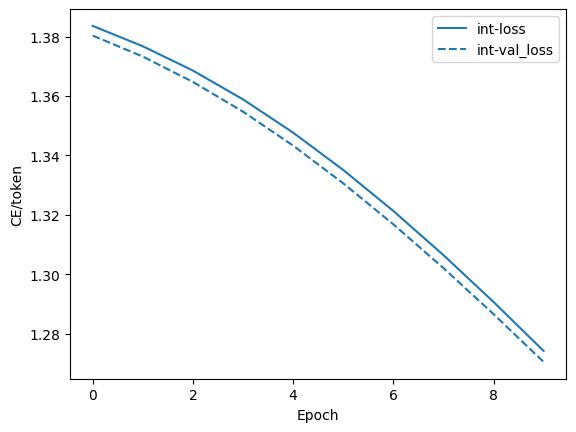

In [ ]:
loss = plt.plot(history.epoch, history.history['loss'], label='int-loss')
plt.plot(history.epoch, history.history['val_loss'], '--', color=loss[0].get_color(), label='int-val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

Model 2

In [ ]:
model2 = tf.keras.Sequential([
    int_vectorize_layer,
    tf.keras.layers.Embedding(
        input_dim=len(int_vectorize_layer.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4)
])

model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization_4                 │ (None, 250)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_9 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history_1 = model.fit(raw_train_ds, epochs=10,
                    validation_data=raw_val_ds)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6959 - loss: 1.2501 - val_accuracy: 0.6687 - val_loss: 1.2420
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7012 - loss: 1.2322 - val_accuracy: 0.6787 - val_loss: 1.2248
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7068 - loss: 1.2141 - val_accuracy: 0.6825 - val_loss: 1.2075
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7098 - loss: 1.1959 - val_accuracy: 0.6856 - val_loss: 1.1903
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7153 - loss: 1.1776 - val_accuracy: 0.6875 - val_loss: 1.1732
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.7193 - loss: 1.1595 - val_accuracy: 0.6894 - val_loss: 1.1563
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7210 - loss: 1.1414 - val_accuracy: 0.6913 - val_loss: 1.1396
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.7237 - loss: 1.1236 - val_accurac

Text(0, 0.5, 'CE/token')

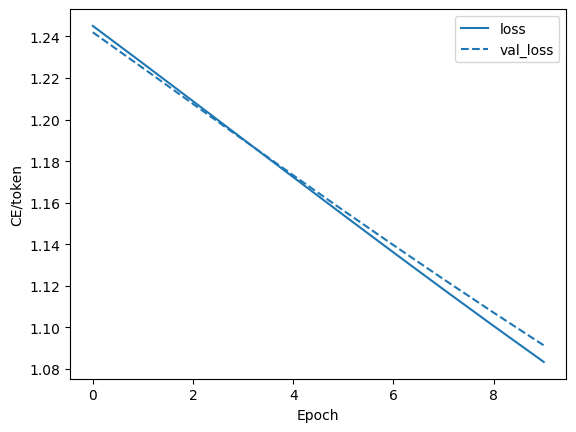

In [ ]:
loss = plt.plot(history_1.epoch, history_1.history['loss'], label='loss')
plt.plot(history_1.epoch, history_1.history['val_loss'], '--', color=loss[0].get_color(), label='val_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('CE/token')

[Source]('https://www.tensorflow.org/tutorials/keras/text_classification')
